In [1]:
import sys
sys.path.append('/Users/rkucharski/Documents/GitHub/Shareability')
import pandas as pd
from matplotlib.collections import LineCollection
pd.options.mode.chained_assignment = None

In [2]:
from sblt_utils import *
from sblt import *

In [3]:
params = get_config('../configs/experiments.json')
params = make_paths(params)
import pprint
pprint.pprint(params.shareability)

FileNotFoundError: [Errno 2] No such file or directory: '../configs/experiments.json'

In [8]:
inData = load_G(inData, params, stats = True) # download the Amsterdam graph

In [16]:
s = pd.read_csv(os.path.join('../res/res/{}.csv'.format('schedule')))
r = pd.read_csv(os.path.join('../res/res/{}.csv'.format('FIFOLIFO')))

In [62]:
def plot_map_rides(G,ts, light = True, m_size = 30, lw = 3):
    def add_route(ax,route, color = 'grey',lw=2,alpha = 0.5):
        #plots route on the graph alrready plotted on ax
        edge_nodes = list(zip(route[:-1], route[1:]))
        lines=[]
        for u, v in edge_nodes:
            # if there are parallel edges, select the shortest in length
            data = min(G.get_edge_data(u, v).values(), key=lambda x: x['length'])
             # if it has a geometry attribute (ie, a list of line segments)
            if 'geometry' in data:
                # add them to the list of lines to plot
                xs, ys = data['geometry'].xy
                lines.append(list(zip(xs, ys)))
            else:
                # if it doesn't have a geometry attribute, the edge is a straight
                # line from node to node
                x1 = G.nodes[u]['x']
                y1 = G.nodes[u]['y']
                x2 = G.nodes[v]['x']
                y2 = G.nodes[v]['y']
                line = [(x1, y1), (x2, y2)]
                lines.append(line)
        lc = LineCollection(lines, colors=color, linewidths=lw, alpha=alpha, zorder=3)
        ax.add_collection(lc)
    G = inData.G
    fig, ax = ox.plot_graph(G, fig_height=15, fig_width=15,node_size=0, edge_linewidth=0.3,
                                show=False, close=False, 
                                edge_color='grey')
    
    colors = {1:'navy',2:'teal',3:'maroon', 4: 'black', 5:'green'}
    
    for t in ts:
        
        orig_points_lats,orig_points_lons,dest_points_lats,dest_points_lons = [],[],[],[]
        deg = t.req_id.nunique()
        count = 0
        for i in t.req_id.unique():
            count+=1
            r = t[t.req_id==i]
            
            o = r[r.od=='o'].iloc[0].node
            d = r[r.od=='d'].iloc[0].node

            

            
            
            if not light:
                ax.annotate('O: '+str(count), (G.nodes[o]['x']*1.0003, G.nodes[o]['y']*1.00002))
                ax.annotate('D: '+str(count), (G.nodes[d]['x']*1.0003, G.nodes[d]['y']*1.00002))
                route = nx.shortest_path(G, o, d, weight='length')

                add_route(ax,route, color = 'black',lw=lw/2,alpha = 0.5)
            ax.scatter(G.nodes[o]['x'], G.nodes[o]['y'],s=m_size,c=colors[deg],marker='*')            
            ax.scatter(G.nodes[d]['x'], G.nodes[d]['y'],s=m_size,c=colors[deg],marker=4)
        
        routes = list() #ride segments 
        o = t.node.values[0]
        for d in t.node.values[1:]:
            routes.append(nx.shortest_path(G, o, d, weight='length'))
            o = d
        for route in routes:
            add_route(ax,route, color = colors[deg],lw=lw,alpha = 0.7)
    plt.tight_layout()
    plt.savefig('map.png')

In [49]:
def make_schedule(t, r):
    columns = ['node', 'times', 'req_id', 'od']
    degree = 2 * len(ast.literal_eval(t.indexes))
    df = pd.DataFrame(None, index=range(degree), columns=columns)
    x = ast.literal_eval(t.indexes_orig)
    s = [r.loc[i].origin for i in x] + [r.loc[i].destination for i in x]
    df.node = pd.Series(s)
    df.req_id = x + ast.literal_eval(t.indexes_dest)
    df.times = t.times
    df.od = pd.Series(['o'] * len(ast.literal_eval(t.indexes)) + ['d'] * len(ast.literal_eval(t.indexes)))
    return df

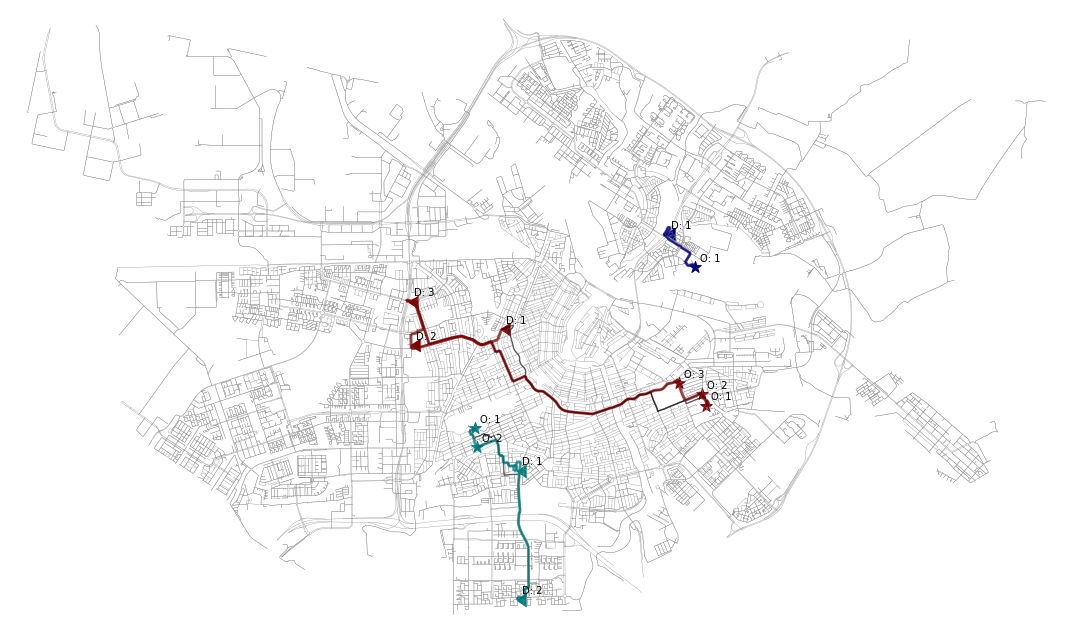

In [63]:
t1 = make_schedule(s.iloc[1],r)
t2 = make_schedule(s[s.kind==20].iloc[1],r)
t3 = make_schedule(s[s.kind==31].iloc[3],r)
plot_map_rides(inData.G,[t1,t2,t3],light= False, m_size = 150)